In [28]:
import numpy as np
from numpy.random import uniform, exponential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.plotting import plot_lifetimes

# Creating dummy data

In [3]:
N = 25
CURRENT_TIME = 10

In [4]:
np.random.seed(42)

actual_lifetimes = np.array([
    exponential(12) if (uniform() < 0.5) else exponential(2) for i in range(N)
])
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

actual_lifetimes2 = np.array([
    exponential(12) if (uniform() < 0.1) else exponential(2) for i in range(N)
])
observed_lifetimes2 = np.minimum(actual_lifetimes2, CURRENT_TIME)
death_observed2 = actual_lifetimes2 < CURRENT_TIME

df = pd.DataFrame({
    'actual_lifetimes': actual_lifetimes.tolist() + actual_lifetimes2.tolist(),
    'observed_lifetimes': observed_lifetimes.tolist() + observed_lifetimes2.tolist(),
    'death_observed': death_observed.tolist() + death_observed2.tolist(),
    'group': [1]*N + [2]*N,
})
print(df.shape)
df.head()

(50, 4)


,actual_lifetimes,observed_lifetimes,death_observed,group
0,36.121457,10.000000,False,1
1,1.825885,1.825885,True,1
2,2.035156,2.035156,True,1
3,24.134770,10.000000,False,1
4,2.462500,2.462500,True,1


- each datapoint corresponds to a person
- each person 'lives' for a certain duration - their lifetime
- the key concept of survival analysis is censoring
- this means that for currently alive individuals we can not get a correct estimate of their lifetime
- this is the difference between `actual_lifetime` and `observed_lifetime`, which we can see because this is synthetic data

In [6]:
(df['observed_lifetimes'] <= df['actual_lifetimes']).all()

True

In [5]:
((df['actual_lifetimes'] == df['observed_lifetimes']) == df['death_observed']).all()

True

C:\Users\R\anaconda3\lib\site-packages\lifelines\plotting.py:702: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


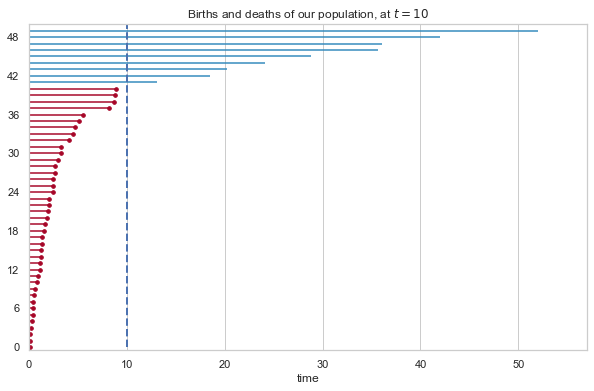

In [58]:
fig, ax = plt.subplots(figsize=(10,6))
plot_lifetimes(df['actual_lifetimes'], event_observed=df['death_observed'], ax=ax)

ax.grid(False, axis='y')
ax.set_xlim(0, df['actual_lifetimes'].max()+5)
ax.vlines(CURRENT_TIME, 0, N*2+5, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title(f"Births and deaths of our population, at $t={CURRENT_TIME}$");

- difference between observed and actual lifetime in chart
- censoring visualization
- compare with supervised learning framework (underestimating lifetime)
- x-axis doesn't need to be calendar time (can be subscription candence which will be different for different customer groups but global anlaysis will work nonetheless)

# Survival function

In [59]:
kmf = KaplanMeierFitter()
kmf.fit(df['observed_lifetimes'], event_observed=df['death_observed'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 50 total observations, 9 right-censored observations>

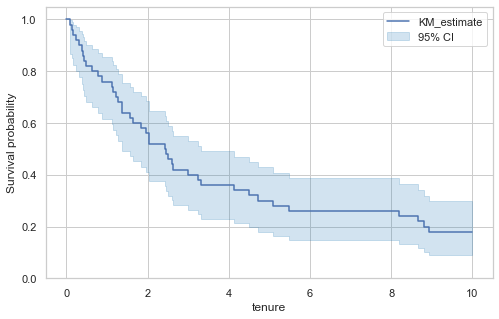

In [61]:
# manual version of chart
fig, ax = plt.subplots(figsize=(8,5))
kmf.survival_function_.plot(drawstyle='steps-post', ax=ax)
ax.fill_between(kmf.confidence_interval_.index, 
                kmf.confidence_interval_['KM_estimate_lower_0.95'], 
                kmf.confidence_interval_['KM_estimate_upper_0.95'],
                step='post', color='tab:blue', alpha=0.2, label='95% CI')
ax.set(xlabel='tenure', ylabel='Survival probability')
ax.legend()
ax.set_ylim(0,1.05);

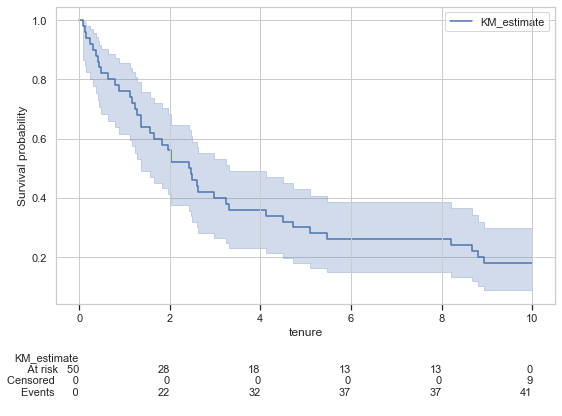

In [63]:
ax = kmf.plot_survival_function(at_risk_counts=True, figsize=(8,6))
ax.set(xlabel='tenure', ylabel='Survival probability')
ax.legend()

- even though t=10 is the max available in the data we don't reach 0 probability since the model knows there is uncertainty in the endpoints
- this is the gap that would be present with a simple superbised learning setup
- median survival time as summary metric
- regimes of falloff

C:\Users\R\anaconda3\lib\site-packages\lifelines\plotting.py:939: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


<AxesSubplot:xlabel='timeline'>

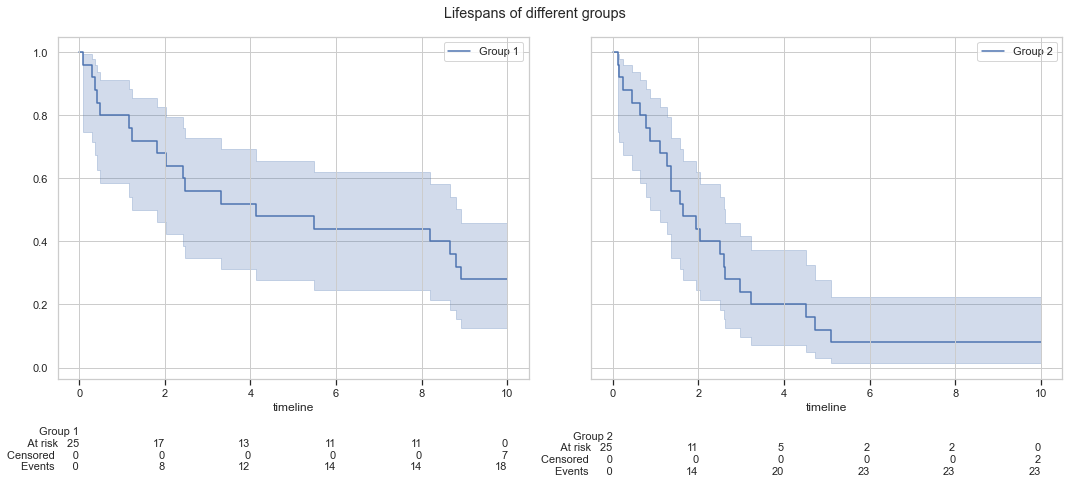

In [11]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,7), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle("Lifespans of different groups");

kmf.fit(df.loc[df['group'] == 1, 'observed_lifetimes'], event_observed=df.loc[df['group'] == 1, 'death_observed'], label="Group 1")
kmf.plot_survival_function(at_risk_counts=True, ax=ax1)

kmf.fit(df.loc[df['group'] == 2, 'observed_lifetimes'], event_observed=df.loc[df['group'] == 2, 'death_observed'], label="Group 2")
kmf.plot_survival_function(at_risk_counts=True, ax=ax2)

- comparison of 2 groups
- different median survival times
- different falloffs
- hint at differences between the groups (link to next notebook with actual example)

# Hazard function

- different ways to extract survival information
- hazard function is core of more complex analyses
- can not just do 1-survival (it will underestimate)
- flowchart

<img style='background-color:white' width=500px src='https://lifelines.readthedocs.io/en/latest/_images/map.png'></img>

In [29]:
naf = NelsonAalenFitter()
naf.fit(df['observed_lifetimes'], event_observed=df['death_observed'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 50 total observations, 9 right-censored observations>

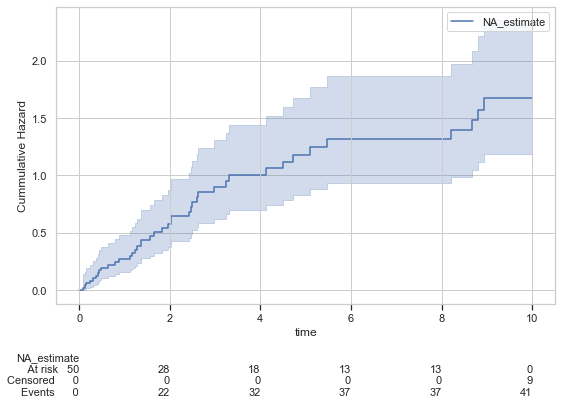

In [55]:
ax = naf.plot_cumulative_hazard(at_risk_counts=True, figsize=(8,6))
ax.set(xlabel='time', ylabel='Cummulative Hazard')

- we estimate cummulative hazard because it is numerically stable
- but we can extract point-wise hazard rate by doing derivative operation (needs to be smoothed because of discretization issues)

[Text(0.5, 0, 'time'), Text(0, 0.5, 'Hazard Rate (smoothed)')]

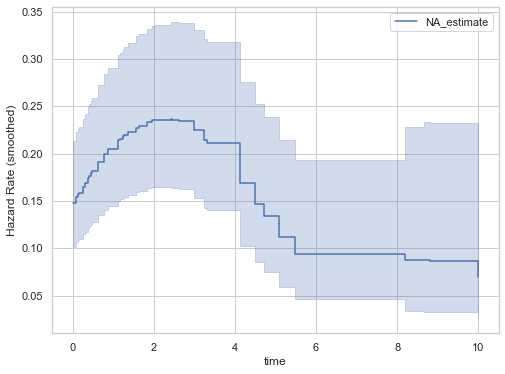

In [57]:
ax = naf.plot_hazard(bandwidth=3, figsize=(8,6))
ax.set(xlabel='time', ylabel='Hazard Rate (smoothed)')